# Plot results of the experiment

## Import

In [1]:
running_on_colab = False
if 'google.colab' in str(get_ipython()):
    running_on_colab = True
    !pip install gpytorch
    !pip install botorch
    !git clone https://github.com/abauville/Bayes-opt-challenge.git
    !cp /content/Bayes-opt-challenge/bayes_lib.py .
    
import numpy as np
import matplotlib.pyplot as plt
from bayes_lib import baseline_model
from botorch.test_functions.synthetic import Hartmann
import os

     |████████████████████████████████| 310 kB 27.2 MB/s 
  Created wheel for gpytorch: filename=gpytorch-1.6.0-py2.py3-none-any.whl size=509889 sha256=db7b3f4a946f290031818e10e7418a663526ed04c63183441d24903233f6e50e
  Stored in directory: /root/.cache/pip/wheels/66/b5/89/34c06ad393a6feb72b4cdde46d0f1c667f3e2632960f9df109
Successfully built gpytorch
     |████████████████████████████████| 363 kB 26.7 MB/s 
     |████████████████████████████████| 713 kB 51.3 MB/s 
Cloning into 'Bayes-opt-challenge'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 29 (delta 0), reused 29 (delta 0), pack-reused 0
Unpacking objects: 100% (29/29), done.


## Define the ground truth function

In [2]:
def gt_func(x):
    """Ground truth function: negative hartmann 6
    The Bayes opt library we use aims to maximize functions by default.
    We use the negated function to effectively minimize it, i.e. argmin(f(x)) = argmax(-f(x))
    """
    hart = Hartmann()
    return - hart.evaluate_true(x)

## Define the model evaluation metric

In [3]:
def error_gap(current_best):
    """Returns the absolute difference between the global minimum of the hartmann 6 function
    and the current best value
            Error gap := |min f(x*) -  current best|
    """
    hart = Hartmann()
    return abs(current_best - (- hart.optimal_value))

## Load model results

In [4]:
if running_on_colab:
    output_folder = "Bayes-opt-challenge/output"
else:
    output_folder = "output"

files = list(filter(lambda x: x[-4:]==".npy", os.listdir(output_folder)))
results = []
for file in files:
    results.append(np.load(f"{output_folder}/{file}"))
results = np.array(results)

## Compute baseline results

In [5]:
n_exp = results.shape[0]
n_iter = results.shape[1]

baseline_results = np.array([baseline_model(gt_func, n_iter, int(1e4)) for i in range(n_exp)])

## Plot

In [6]:
def plot_series(X, label=''):
    means = np.mean(X,0)
    p_low, p_high = np.quantile(X,(.05,.95),0)
    
    ax.plot(means, label=label)
    ax.fill_between(np.arange(n_iter), 
                    p_low, 
                    p_high, 
                    alpha=0.2)

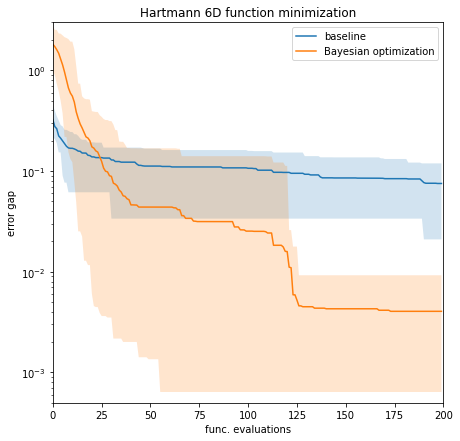

In [7]:
fig, ax = plt.subplots(1,1,figsize=[7,7])
plot_series(error_gap(baseline_results), label='baseline')
plot_series(error_gap(results), label='Bayesian optimization')
plt.ylim([0.0005,3])
plt.xlim(0,results.shape[1])
ax.set_yscale('log')
plt.legend()
plt.title("Hartmann 6D function minimization")
plt.ylabel("error gap")
plt.xlabel("func. evaluations")
plt.savefig("hartmann_min.png")

<figcaption>Fig. 1. Comparison between Bayesian optimization (BayesOpt, orange) and a baseline model (blue). BayesOpt was run using a Gaussian process surrogate model and the expected improvement aquisition function, with 20 initial samples and one new sample aquired at each iteration. The baseline model samples 10^4 random points from a uniform distribution at each iteration. Each model was performed 20 times, and the figure shows the mean (solid line) and the 5-95 percentile region (color-filled area).'</figcaption>